##  Credit Scoring with Zeetapark for Python

In this notebook, we are going to use the [Zettapark](https://www.singdata.com/documents) Python API to run through a credit card scoring demo.

In this scenario, Zettabank wants to use their existing credit files to analyze the current credit standings on whether the loans are being paid without any issues, and/or if there are any delays/default. 

Based on the current credit standing, Zettabank wants to build a machine learning credit scoring algorithm based on the dataset to be able to automate an assessment on whether a loan should be approved or declined.

### Prerequisite

Please run the Credit Scoring Demo Setup Notebook prior to running this demo.

### 1. Data Exploration

In this section, we will explore the dataset for the existing credits.

#### 1.1 Opening a Singdata Lakehouse Session

In [1]:
import json

import pandas as pd
from clickzetta.zettapark import *
from clickzetta.zettapark.functions import *

In [2]:
# read connection para from config file
with open('config/config.json', 'r') as config_file:
    config = json.load(config_file)

schema = config['schema']
vcluster = config['vcluster']

print("Connecting to Lakehouse.....\n")

# create session
session = Session.builder.configs(config).create()

session.sql(f"CREATE SCHEMA IF NOT EXISTS {schema}").collect()
session.sql(f"CREATE VCLUSTER IF NOT EXISTS {vcluster} VCLUSTER_SIZE=1 VCLUSTER_TYPE = GENERAL").collect()

print(session.sql("SELECT current_instance_id(), current_workspace(),current_workspace_id(), current_schema(), current_user(),current_user_id(), current_vcluster()").collect())

print("\nConnected！...\n")

Connecting to Lakehouse.....

[Row(current_instance_id()=123, current_workspace()='qiliang_ws_demo', current_workspace_id()=3539727324115904866, `current_schema`()='credit_scoring_sch', `current_user`()='liangmo', current_user_id()=2162629, current_vcluster()='credit_scoring_vc')]

Connected！...



#### 1.2 Explore Data in Lakehouse table

In [3]:
credit_df = session.table("CREDIT_FILES")

In [4]:
credit_df.describe().toPandas()

,summary,credit_request_id,credit_amount,credit_duration,purpose,installment_commitment,other_parties,credit_standing,credit_score,checking_balance,...,assets,housing,qualification,job_history,age,sex,marital_status,num_dependents,residence_since,other_payment_plans
0,max,3000.000000,184240.000000,72.000000,Vehicle,4.00000,Guarantor,good,799.000000,4992.000000,...,Vehicle,rent,unskilled,25.000000,75.000000,M,Single,2.000000,4.000000,stores
1,mean,1502.253061,32593.571429,20.885034,0,2.97449,0,0,603.929592,344.497456,...,0,0,0,5.726531,35.914286,0,0,1.155442,2.847279,0
2,min,1.000000,2500.000000,4.000000,Business,1.00000,Co-Applicant,bad,200.000000,-999.460000,...,Home,free,highly skilled,0.000000,19.000000,F,Divorced,1.000000,1.000000,bank
3,count,2940.000000,2940.000000,2940.000000,2940,2940.00000,271,2940,2940.000000,2940.000000,...,2489,2940,2940,2940.000000,2940.000000,2940,2940,2940.000000,2940.000000,2940
4,stddev,865.281708,27992.343428,12.049816,0,1.11702,0,0,149.279673,1065.638529,...,0,0,0,6.589818,11.246207,0,0,0.362387,1.103742,0


In [5]:
credit_df.toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2940 entries, 0 to 2939
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   credit_request_id       2940 non-null   int64  
 1   credit_amount           2940 non-null   int64  
 2   credit_duration         2940 non-null   int64  
 3   purpose                 2940 non-null   object 
 4   installment_commitment  2940 non-null   int64  
 5   other_parties           271 non-null    object 
 6   credit_standing         2940 non-null   object 
 7   credit_score            2940 non-null   int64  
 8   checking_balance        2940 non-null   float64
 9   savings_balance         2940 non-null   float64
 10  existing_credits        2940 non-null   int64  
 11  assets                  2489 non-null   object 
 12  housing                 2940 non-null   object 
 13  qualification           2940 non-null   object 
 14  job_history             2940 non-null   

In [6]:
credit_df.toPandas()

,credit_request_id,credit_amount,credit_duration,purpose,installment_commitment,other_parties,credit_standing,credit_score,checking_balance,savings_balance,...,assets,housing,qualification,job_history,age,sex,marital_status,num_dependents,residence_since,other_payment_plans
0,147,8600,6,Vehicle,1,None,good,466,-728.12,17.00,...,None,own,skilled,15,39,F,Married,1,4,none
1,248,12040,6,Vehicle,4,None,good,202,0.00,2443.00,...,None,rent,skilled,1,35,M,Single,1,1,bank
2,112,3920,15,Tuition,4,None,good,736,4696.00,143.00,...,Investments,rent,skilled,1,23,F,Married,1,4,none
3,222,12000,12,Tuition,4,None,good,732,-25.35,0.00,...,Investments,rent,skilled,3,23,F,Married,1,4,bank
4,162,10550,18,Vehicle,4,None,good,507,0.00,510.00,...,Investments,own,skilled,1,30,F,Married,1,1,none
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2935,2311,53810,48,Other,3,None,good,726,1505.00,0.00,...,None,free,unemployed,0,40,M,Single,1,4,bank
2936,2775,14800,12,Vehicle,2,None,good,343,4486.00,7361.86,...,None,free,unemployed,0,66,M,Single,1,4,bank
2937,2188,11750,16,Vehicle,2,None,good,396,720.00,460.00,...,Vehicle,free,unemployed,0,68,M,Single,1,3,none
2938,2000,45760,45,Vehicle,3,None,good,523,752.00,1444.00,...,Vehicle,own,skilled,0,27,M,Single,1,4,none


#### 1.3  Visualizing the Numeric Features

From this visualization, we can see a few interesting characteristics:

* Most of the credit requests are for small amounts (< 50k)
* Most of the credit terms are 20 months or less.
* Most of the applicants have a very good credit score.
* Most of the applicants do not have a lot of balance in either credits or savings with Zettabank.
* Most of the applicants are less than 40 years old.

array([[<Axes: title={'center': 'credit_request_id'}>,
        <Axes: title={'center': 'credit_amount'}>,
        <Axes: title={'center': 'credit_duration'}>],
       [<Axes: title={'center': 'installment_commitment'}>,
        <Axes: title={'center': 'credit_score'}>,
        <Axes: title={'center': 'checking_balance'}>],
       [<Axes: title={'center': 'savings_balance'}>,
        <Axes: title={'center': 'existing_credits'}>,
        <Axes: title={'center': 'job_history'}>],
       [<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'num_dependents'}>,
        <Axes: title={'center': 'residence_since'}>]], dtype=object)

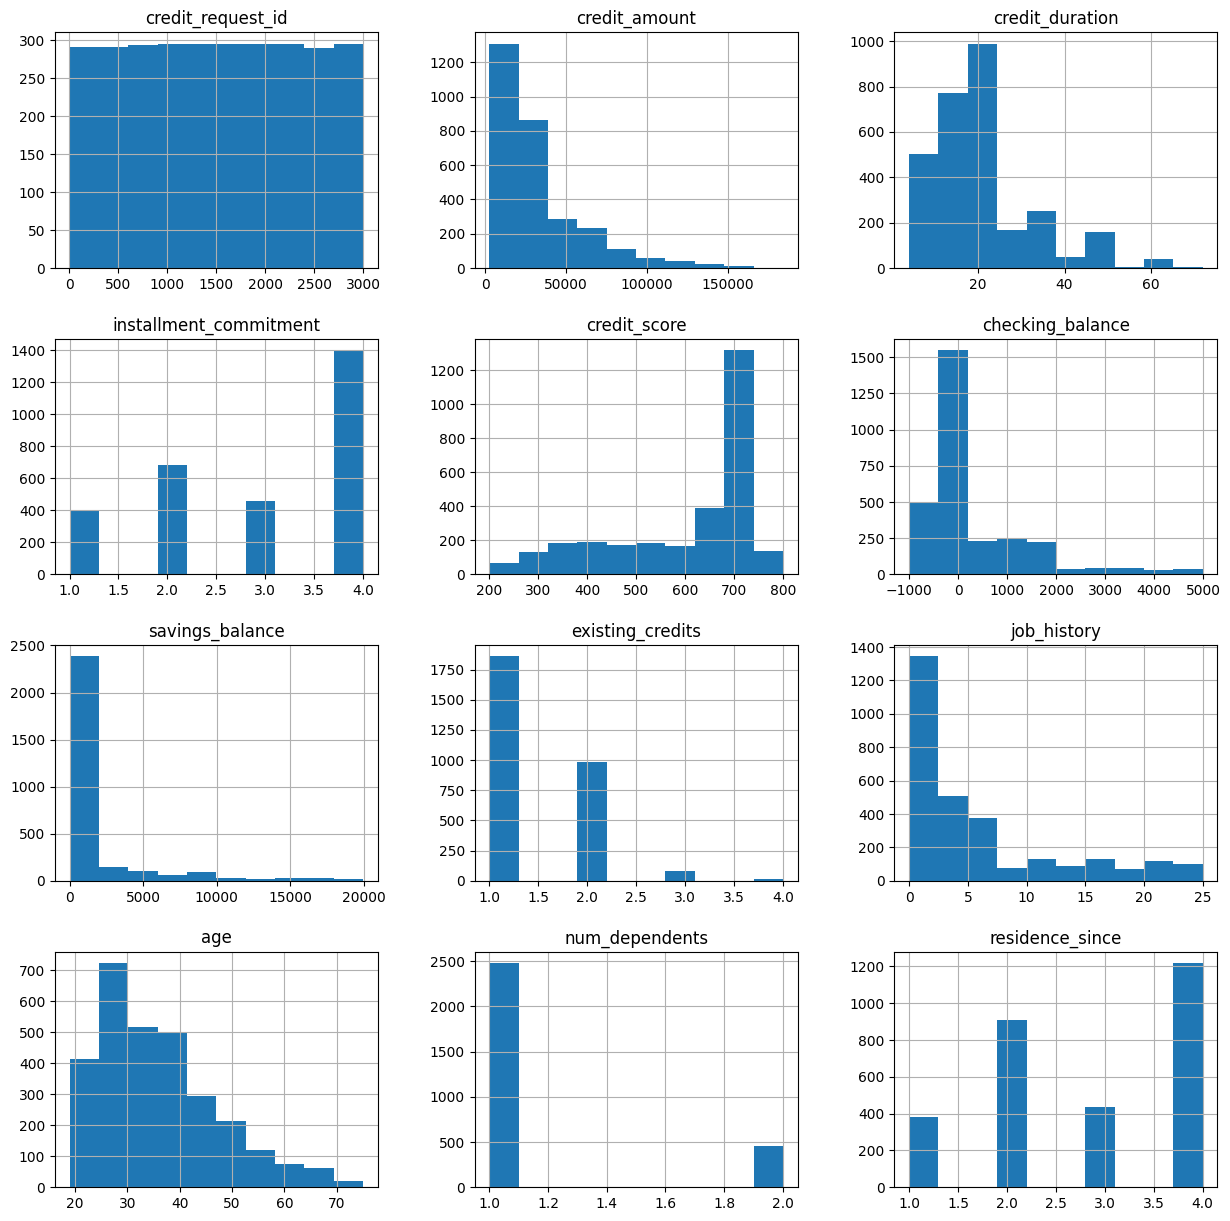

In [7]:
credit_df.toPandas().hist(figsize=(15,15))

#### 1.4  Visualizing the Categorical Features

From this visualization, we can see a few interesting characteristics:

* Most of the popular credit requests are related to either a vehicle purchase or consumer goods.
* The vast majority of loans do not have guarantors, nor co-applicants.
* Most of credit in file is in good standing.
* The majority of the applicants are male, foreign workers, and skilled who own their own house/apartment.
* Higher amounts of loans (which threshold varies per category of loan) have a higher chance of defaulting.

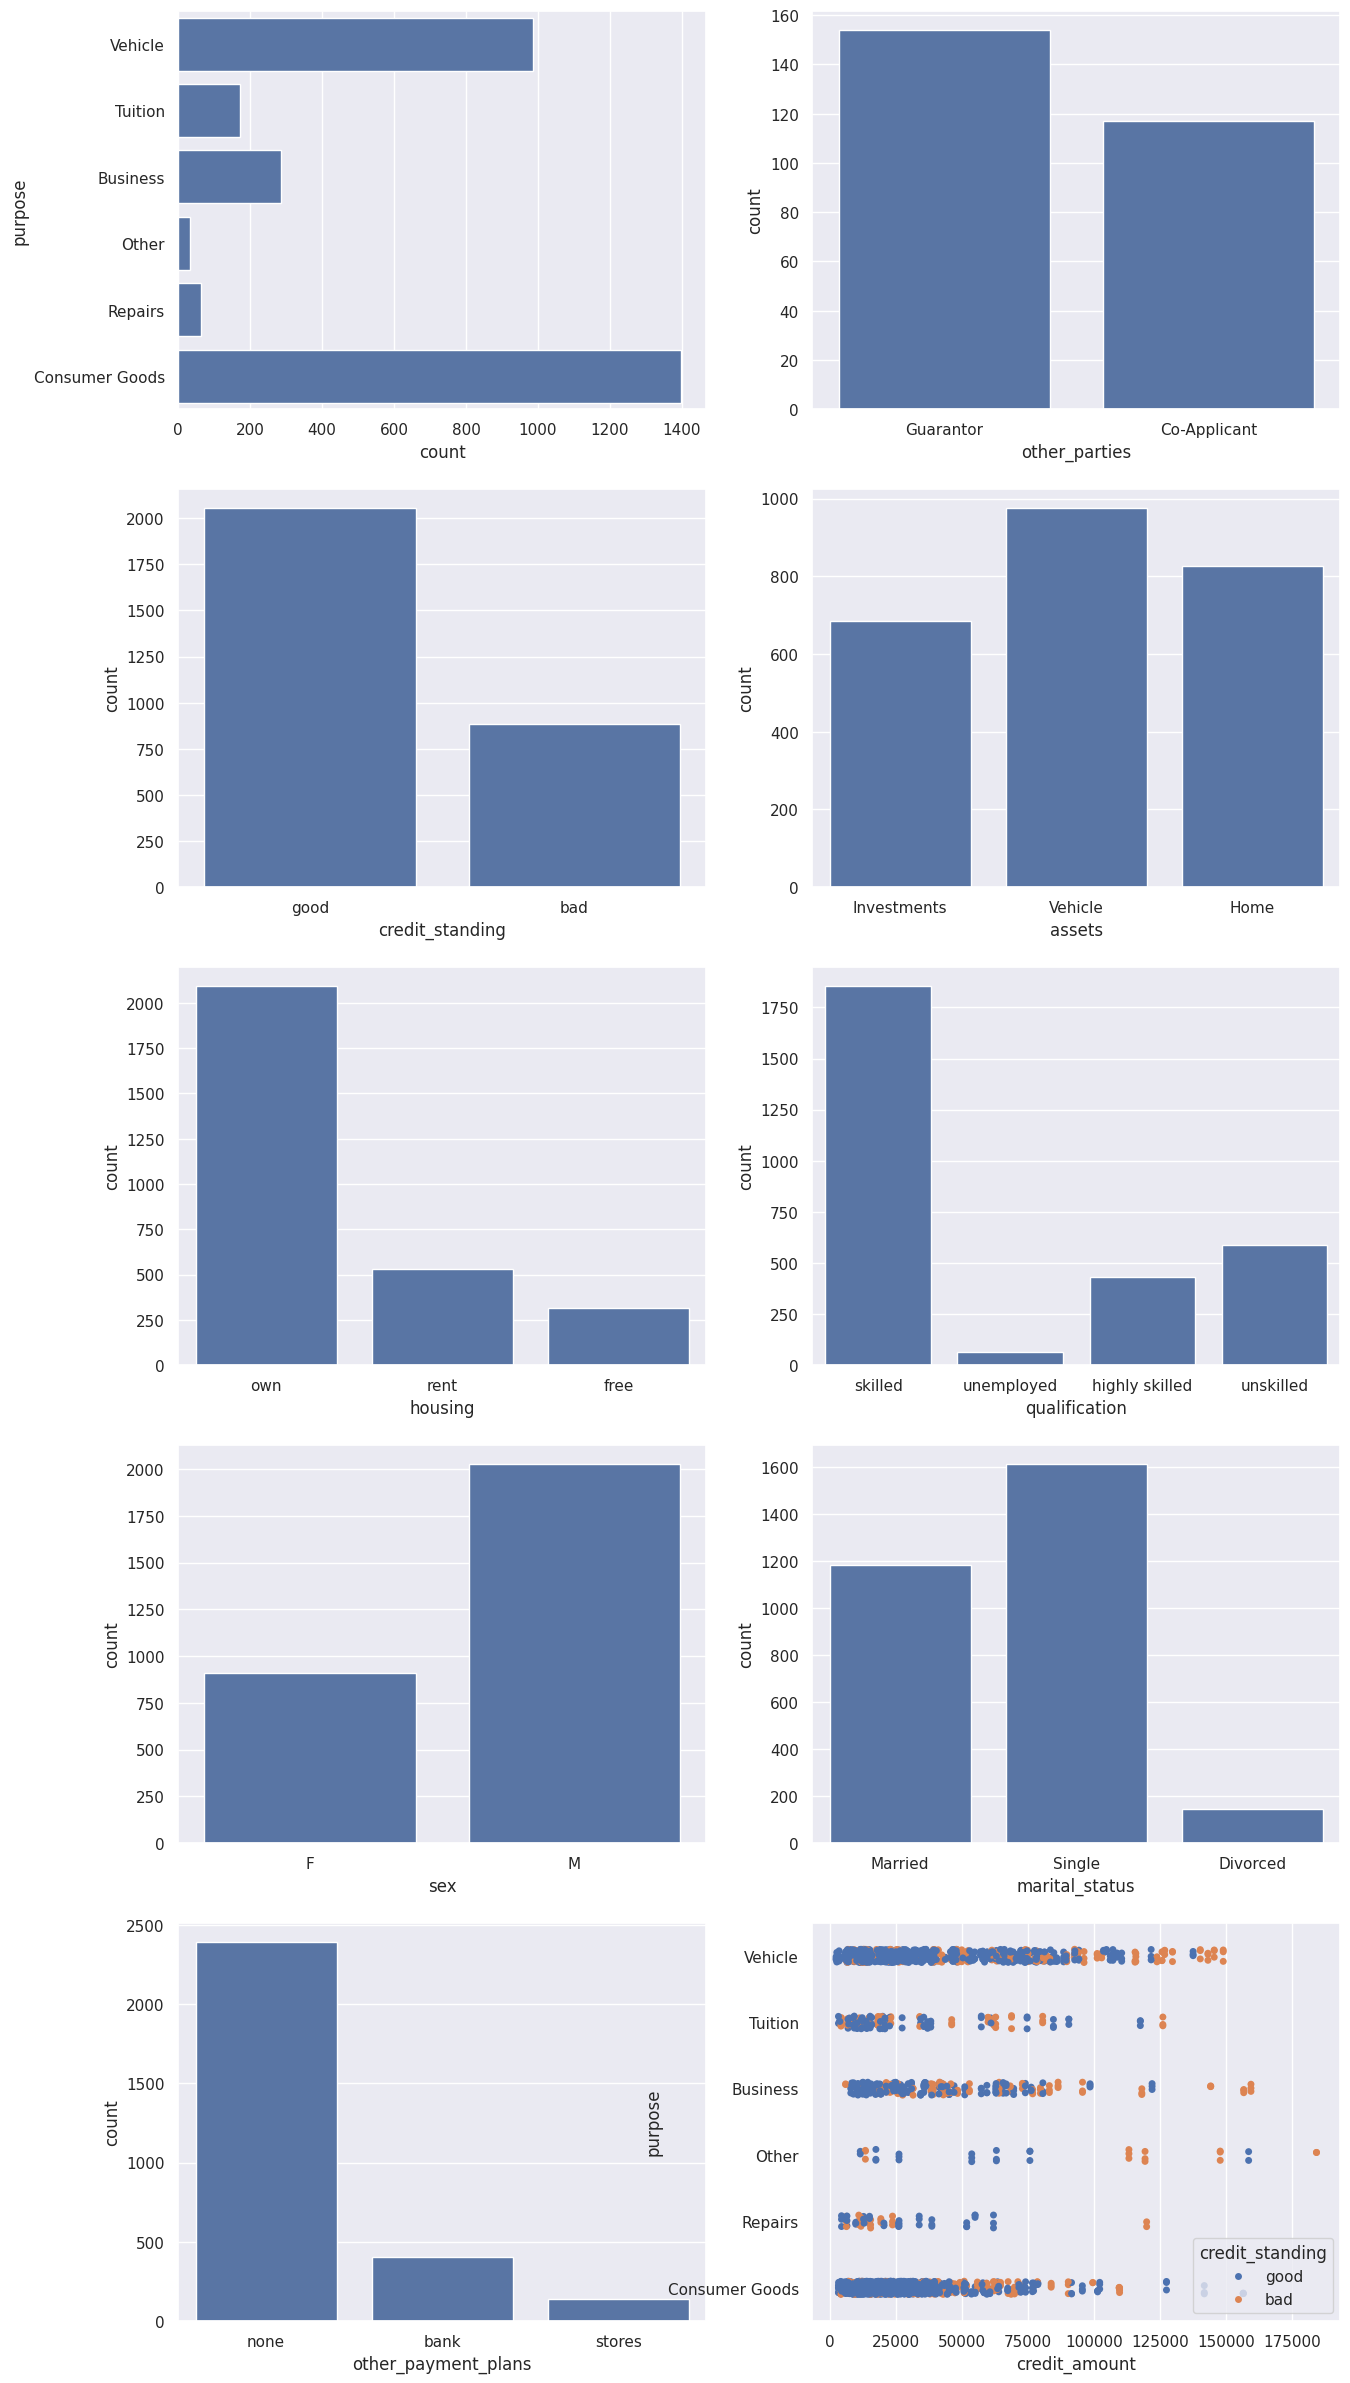

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")

fig, axs = plt.subplots(5, 2, figsize=(15, 30))
df = credit_df.toPandas()
sns.countplot(data=df, y="purpose", ax=axs[0,0])
sns.countplot(data=df, x="other_parties", ax=axs[0,1])
sns.countplot(data=df, x="credit_standing", ax=axs[1,0])
sns.countplot(data=df, x="assets", ax=axs[1,1])
sns.countplot(data=df, x="housing", ax=axs[2,0])
sns.countplot(data=df, x="qualification", ax=axs[2,1])
sns.countplot(data=df, x="sex", ax=axs[3,0])
sns.countplot(data=df, x="marital_status", ax=axs[3,1])
sns.countplot(data=df, x="other_payment_plans", ax=axs[4,0])
sns.stripplot(y="purpose", x="credit_amount", data=df, hue='credit_standing', jitter=True, ax=axs[4,1])
plt.show()

#### 1.5 Running queries through Zettapark API

We can use the Zettapark API to run queries to get various insights. For example, let's try to determine the range of f loans per different category. We can check the Singdata Lakehouse query history and review how the Zettapark API has been pushed down as SQL.

In [9]:
df_loan_status = credit_df.select(col("PURPOSE"),col("CREDIT_AMOUNT"))\
                          .groupBy(col("PURPOSE"))\
                          .agg([min(col("CREDIT_AMOUNT")).as_("MIN_CREDIT_AMOUNT"), max(col("CREDIT_AMOUNT")).as_("MAX_CREDIT_AMOUNT"), median(col("CREDIT_AMOUNT")).as_("MED_CREDIT_AMOUNT"),avg(col("CREDIT_AMOUNT")).as_("AVG_CREDIT_AMOUNT")])\
                          .sort(col("PURPOSE"))
df_loan_status.toPandas()

,purpose,min_credit_amount,max_credit_amount,med_credit_amount,avg_credit_amount
0,Business,6090,159450,31610.0,41863.146853
1,Consumer Goods,3380,156530,21080.0,26791.788269
2,Other,11640,184240,63140.0,78815.454545
3,Repairs,4540,119980,15550.0,25854.769231
4,Tuition,3390,126120,15970.0,29122.965116
5,Vehicle,2500,148960,26745.0,37633.569980


### 2. Data Transformation and Encoding


For the current use case, in order to prepare the data for machine learning, we need to encode the categorical values into numerical. 

In order to achieve this, we can leverage Zettapark Python API in order to perform the encoding.

#### 2.1 Preparing the Feature Matrix for ML

In this section, we are going to leverage the Zettapark Python API in order to prepare a feature matrix for a Random Forest Classifier Model.

In [10]:
from clickzetta.zettapark.functions import when

feature_matrix = credit_df.select(
    when(col("purpose") == "Consumer Goods", 1)
    .when(col("purpose") == "Vehicle", 2)
    .when(col("purpose") == "Tuition", 3)
    .when(col("purpose") == "Business", 4)
    .when(col("purpose") == "Repairs", 5)
    .otherwise(0).alias("purpose_code"),
    when(col("qualification") == "unskilled", 1)
    .when(col("qualification") == "skilled", 2)
    .when(col("qualification") == "highly skilled", 3)
    .otherwise(0).alias("qualification_code"),
    when(col("other_parties") == "Guarantor", 1)
    .when(col("other_parties") == "Co-Applicant", 2)
    .otherwise(0).alias("other_parties_code"),
    when(col("other_payment_plans") == "bank", 1)
    .when(col("other_payment_plans") == "stores", 2)
    .otherwise(0).alias("other_payment_plans_code"),
    when(col("housing") == "rent", 1)
    .when(col("housing") == "own", 2)
    .otherwise(0).alias("housing_code"),
    when(col("assets") == "Vehicle", 1)
    .when(col("assets") == "Investments", 2)
    .when(col("assets") == "Home", 3)
    .otherwise(0).alias("assets_code"),
    when(col("sex") == "M", 1)
    .otherwise(0).alias("sex_code"),
    when(col("marital_status") == "Married", 1)
    .when(col("marital_status") == "Single", 2)
    .otherwise(0).alias("marital_status_code"),
    when(col("credit_standing") == "good", 1)
    .otherwise(0).alias("credit_standing_code"),
    col("checking_balance"),
    col("savings_balance"),
    col("age"),
    col("job_history"),
    col("credit_score"),
    col("credit_duration"),
    col("credit_amount"),
    col("residence_since"),
    col("installment_commitment"),
    col("num_dependents"),
    col("existing_credits")
)

feature_matrix_pandas = feature_matrix.toPandas()
print(feature_matrix_pandas)                                

      purpose_code  qualification_code  other_parties_code  \
0                2                   2                   0   
1                2                   2                   0   
2                3                   2                   0   
3                3                   2                   0   
4                2                   2                   0   
...            ...                 ...                 ...   
2935             0                   0                   0   
2936             2                   0                   0   
2937             2                   0                   0   
2938             2                   2                   0   
2939             2                   2                   0   

      other_payment_plans_code  housing_code  assets_code  sex_code  \
0                            0             2            0         0   
1                            1             1            0         1   
2                            0            

Now that the feature matrix has been defined, we will convert it into a Pandas Dataframe.

In [11]:
df = feature_matrix.toPandas().astype(int)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2940 entries, 0 to 2939
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   purpose_code              2940 non-null   int64
 1   qualification_code        2940 non-null   int64
 2   other_parties_code        2940 non-null   int64
 3   other_payment_plans_code  2940 non-null   int64
 4   housing_code              2940 non-null   int64
 5   assets_code               2940 non-null   int64
 6   sex_code                  2940 non-null   int64
 7   marital_status_code       2940 non-null   int64
 8   credit_standing_code      2940 non-null   int64
 9   checking_balance          2940 non-null   int64
 10  savings_balance           2940 non-null   int64
 11  age                       2940 non-null   int64
 12  job_history               2940 non-null   int64
 13  credit_score              2940 non-null   int64
 14  credit_duration           2940 non-null 

This is what the data looks like:

In [13]:
df.head()

,purpose_code,qualification_code,other_parties_code,other_payment_plans_code,housing_code,assets_code,sex_code,marital_status_code,credit_standing_code,checking_balance,savings_balance,age,job_history,credit_score,credit_duration,credit_amount,residence_since,installment_commitment,num_dependents,existing_credits
0,2,2,0,0,2,0,0,1,1,-728,17,39,15,466,6,8600,4,1,1,2
1,2,2,0,1,1,0,1,2,1,0,2443,35,1,202,6,12040,1,4,1,1
2,3,2,0,0,1,2,0,1,1,4696,143,23,1,736,15,3920,4,4,1,1
3,3,2,0,1,1,2,0,1,1,-25,0,23,3,732,12,12000,4,4,1,1
4,2,2,0,0,2,2,0,1,1,0,510,30,1,507,18,10550,1,4,1,2


### 3. Random Forest Model Training

We are going to leverage the Random Forest Classifier Model available as part of the scikit-learn popular ML Library available in Python.

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop('credit_standing_code', axis=1), 
                                                    df['credit_standing_code'], test_size=0.30)

In [16]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)

RandomForestClassifier()

### 4. Testing the Model

In [17]:
rfc_pred = rfc.predict(X_test)

In [18]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test,rfc_pred))

              precision    recall  f1-score   support

           0       0.93      0.92      0.92       254
           1       0.97      0.97      0.97       628

    accuracy                           0.96       882
   macro avg       0.95      0.95      0.95       882
weighted avg       0.96      0.96      0.96       882



In [19]:
print(confusion_matrix(y_test,rfc_pred))

[[233  21]
 [ 17 611]]


### 5. Performing Inference in Singdata Lakehouse

In the example below, we want to process an existing batch of 60 credit pending requests and provide an assessment on whether the loan should be approved or denied. The data looks like as follows:

In [20]:
df_cred_req = session.table("CREDIT_REQUESTS")

In [21]:
df_cred_req.toPandas()

,credit_request_id,credit_amount,credit_duration,purpose,installment_commitment,other_parties,credit_score,checking_balance,savings_balance,existing_credits,assets,housing,qualification,job_history,age,sex,marital_status,num_dependents,residence_since,other_payment_plans
0,182,44550,36,Business,2,None,656,259.00,628.00,2,Home,own,highly skilled,1,30,M,Divorced,1,2,stores
1,188,11750,16,Vehicle,2,None,549,1892.00,723.00,3,Vehicle,free,unemployed,0,68,M,Single,1,3,none
2,122,38680,24,Vehicle,4,None,356,0.00,586.00,2,Vehicle,rent,highly skilled,7,41,F,Married,1,2,none
3,245,34470,12,Tuition,4,None,749,0.00,8102.00,1,Home,own,unskilled,1,35,F,Married,2,3,none
4,447,18420,36,Vehicle,4,None,672,-463.77,428.00,1,Vehicle,own,skilled,1,34,F,Married,1,4,none
5,581,10560,18,Vehicle,3,Guarantor,479,1676.00,365.00,2,Home,own,skilled,18,36,M,Single,1,3,bank
6,716,75960,30,Vehicle,1,None,327,0.00,0.00,2,Vehicle,own,skilled,10,63,M,Single,1,4,none
7,285,38780,24,Vehicle,4,None,543,1555.00,1885.00,1,Vehicle,own,skilled,1,37,M,Divorced,1,2,none
8,328,15250,24,Vehicle,4,None,676,0.00,11818.00,1,Vehicle,own,skilled,5,34,F,Married,2,3,none
9,488,37570,24,Vehicle,4,Co-Applicant,716,0.00,493.00,1,None,free,skilled,12,62,F,Married,1,4,none


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2940 entries, 0 to 2939
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   purpose_code              2940 non-null   int64
 1   qualification_code        2940 non-null   int64
 2   other_parties_code        2940 non-null   int64
 3   other_payment_plans_code  2940 non-null   int64
 4   housing_code              2940 non-null   int64
 5   assets_code               2940 non-null   int64
 6   sex_code                  2940 non-null   int64
 7   marital_status_code       2940 non-null   int64
 8   credit_standing_code      2940 non-null   int64
 9   checking_balance          2940 non-null   int64
 10  savings_balance           2940 non-null   int64
 11  age                       2940 non-null   int64
 12  job_history               2940 non-null   int64
 13  credit_score              2940 non-null   int64
 14  credit_duration           2940 non-null 

### 6. Develop Function for scoring

As the Zettabank receives the credit requests in near real-time, we want to write a Function which could be called through a task to score micro-batches of requests as they come in. 

The Python Function will first build the input features for the model using the Zettapark API for scoring.

In [23]:
from clickzetta.zettapark.functions import col, when

def process_credit_requests_fn (session, credit_requests: str, credit_assessment: str) -> int:
    
    #Build the input features for the model using the Zettapark API with direct encoding.
    df_cred_req = session.table(credit_requests).select( 
                            col("CREDIT_REQUEST_ID"), col("PURPOSE"),
                            when(col("PURPOSE") == "Consumer Goods", 1)
                            .when(col("PURPOSE") == "Vehicle", 2)
                            .when(col("PURPOSE") == "Tuition", 3)
                            .when(col("PURPOSE") == "Business", 4)
                            .when(col("PURPOSE") == "Repairs", 5)
                            .otherwise(0).alias("PURPOSE_CODE"),
                            when(col("QUALIFICATION") == "unskilled", 1)
                            .when(col("QUALIFICATION") == "skilled", 2)
                            .when(col("QUALIFICATION") == "highly skilled", 3)
                            .otherwise(0).alias("QUALIFICATION_CODE"),
                            when(col("OTHER_PARTIES") == "Guarantor", 1)
                            .when(col("OTHER_PARTIES") == "Co-Applicant", 2)
                            .otherwise(0).alias("OTHER_PARTIES_CODE"),
                            when(col("OTHER_PAYMENT_PLANS") == "bank", 1)
                            .when(col("OTHER_PAYMENT_PLANS") == "stores", 2)
                            .otherwise(0).alias("OTHER_PAYMENT_PLANS_CODE"),
                            when(col("HOUSING") == "rent", 1)
                            .when(col("HOUSING") == "own", 2)
                            .otherwise(0).alias("HOUSING_CODE"),
                            when(col("ASSETS") == "Vehicle", 1)
                            .when(col("ASSETS") == "Investments", 2)
                            .when(col("ASSETS") == "Home", 3)
                            .otherwise(0).alias("ASSETS_CODE"),
                            when(col("SEX") == "M", 1)
                            .otherwise(0).alias("SEX_CODE"),
                            when(col("MARITAL_STATUS") == "Married", 1)
                            .when(col("MARITAL_STATUS") == "Single", 2)
                            .otherwise(0).alias("MARITAL_STATUS_CODE"),
                            col("CHECKING_BALANCE"),
                            col("SAVINGS_BALANCE"),
                            col("AGE"),
                            col("JOB_HISTORY"),
                            col("CREDIT_SCORE"),
                            col("CREDIT_DURATION"), 
                            col("CREDIT_AMOUNT"), 
                            col("RESIDENCE_SINCE"),
                            col("INSTALLMENT_COMMITMENT"),
                            col("NUM_DEPENDENTS"),
                            col("EXISTING_CREDITS")
                         )
    
    # Call the UDF to score the existing credit requests read previously    
    input_features = [ 'PURPOSE_CODE',
                   'QUALIFICATION_CODE',
                   'OTHER_PARTIES_CODE',
                   'OTHER_PAYMENT_PLANS_CODE',
                   'HOUSING_CODE',
                   'ASSETS_CODE',
                   'SEX_CODE',
                   'MARITAL_STATUS_CODE',
                   'CHECKING_BALANCE',
                   'SAVINGS_BALANCE',
                   'AGE',
                   'JOB_HISTORY',
                   'CREDIT_SCORE',
                   'CREDIT_DURATION',
                   'CREDIT_AMOUNT',
                   'RESIDENCE_SINCE',
                   'INSTALLMENT_COMMITMENT',
                   'NUM_DEPENDENTS',
                   'EXISTING_CREDITS']           

    df_assessment = df_cred_req.select(
                    col("CREDIT_REQUEST_ID"), col("PURPOSE"), col("CREDIT_AMOUNT"), col("CREDIT_DURATION"),
                    when(col("CREDIT_SCORE") > 600, "Approved").otherwise("Denied").alias("CREDIT_STATUS"))
    
    df_assessment.write.mode("overwrite").saveAsTable(credit_assessment)
    
    #The function will return the total number of credit requests assessed.
    return df_assessment.count()

### 7. Invoking the Function for scoring

In [24]:
process_credit_requests_fn (session, "credit_requests",  "credit_assessments")

60

In [25]:
session.table("credit_assessments").toPandas()

,credit_request_id,purpose,credit_amount,credit_duration,credit_status
0,182,Business,44550,36,Approved
1,188,Vehicle,11750,16,Denied
2,122,Vehicle,38680,24,Denied
3,245,Tuition,34470,12,Approved
4,447,Vehicle,18420,36,Approved
5,581,Vehicle,10560,18,Denied
6,716,Vehicle,75960,30,Denied
7,285,Vehicle,38780,24,Denied
8,328,Vehicle,15250,24,Approved
9,488,Vehicle,37570,24,Approved
